# Load raster data via WMS

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

import geoengine as ge

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030/api")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030/api
Session Id:          18fec623-6600-41af-b82b-24ccf47cb9f9

## Define workflow of MODIS NDVI raster

In [4]:
workflow = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": {
                "type": "internal",
                "datasetId": "a9623a5b-b6c5-404b-bc5a-313ff72e4e75"
            },
            "attributeProjection": None
        }
    }
})

workflow

69cf7aaf-e828-537e-be9b-31933120c931

## Define a query rectangle

In [5]:
time_start = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime('2014-06-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time_start, time_end),
    ge.SpatialResolution(0.5, 0.5),
)

## Query dataset asynchronously

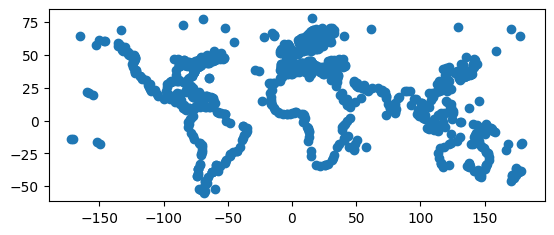

,website,scalerank,name,natlscale,featurecla,geometry,time_start,time_end
0,www.rocargo.com/SanNicolas.html,8,Sint Nicolaas,5.0,Port,MULTIPOINT (-69.92356 12.43750),NaT,NaT
1,www.consejoportuario.com.ar,8,Campana,5.0,Port,MULTIPOINT (-58.95141 -34.15333),NaT,NaT
2,www.consejoportuario.com.ar,8,Zarate,5.0,Port,MULTIPOINT (-59.00495 -34.09889),NaT,NaT
3,None,8,Puerto Belgrano/Bahia Blanca,5.0,Port,MULTIPOINT (-62.10088 -38.89444),NaT,NaT
4,None,8,Puerto Galvan/Bahia Blanca,5.0,Port,MULTIPOINT (-62.30053 -38.78306),NaT,NaT


In [6]:
async for data_frame in workflow.vector_stream(bbox):
    data_frame.plot()
    plt.show()
    display(data_frame.head())

## Query multiple batches of data

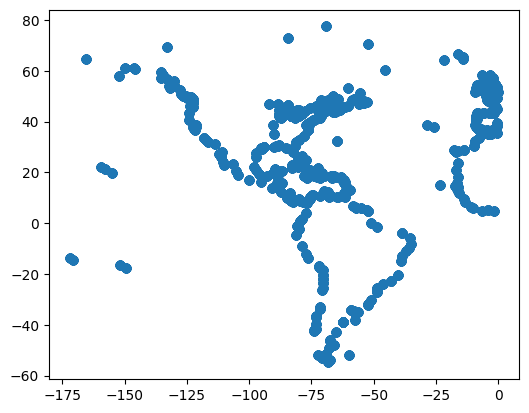

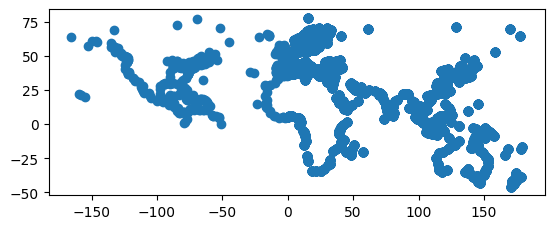

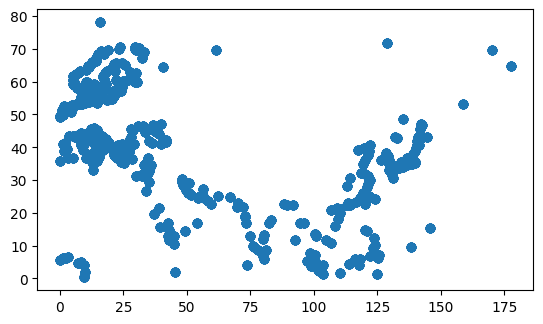

In [7]:
# we create a large data frame by repeating the data frame 160 times…
large_data_frame = pd.concat(
    [
        *[data_frame[['geometry', 'scalerank', 'natlscale']].cx[-180:0, -90:0] for _  in range(40)],
        *[data_frame[['geometry', 'scalerank', 'natlscale']].cx[-180:0, 0:90] for _  in range(40)],
        *[data_frame[['geometry', 'scalerank', 'natlscale']].cx[0:180, -90:0] for _  in range(40)],
        *[data_frame[['geometry', 'scalerank', 'natlscale']].cx[0:180, 0:90] for _  in range(40)],
    ],
    ignore_index=True
)

# …then we upload it to the server…

new_id = ge.upload_dataframe(large_data_frame)

new_workflow = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": {
                "type": "internal",
                "datasetId": str(new_id)
            },
            "attributeProjection": None
        }
    }
})

# …and finally we can stream multiple batches from the server

async for chunk_data_frame in new_workflow.vector_stream(bbox):
    chunk_data_frame.plot()
    plt.show()

## Auto-merge into one geo data frame

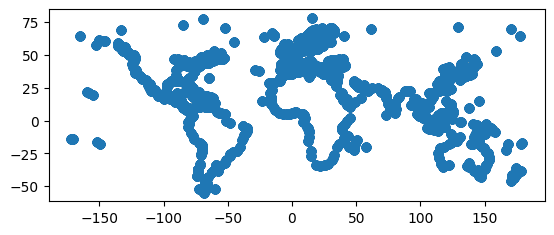

In [8]:
merged_data_frame = await new_workflow.vector_stream_into_geopandas(bbox)
merged_data_frame.plot()
plt.show()